In [ ]:
pip install geopandas

In [ ]:
pip install mapclassify

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet  import Prophet
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
from IPython.display import display
import geopandas as geo
import mapclassify
#datalar https://turcovid19.com/ sitesinden alınmıştır

In [4]:
url = 'https://drive.google.com/file/d/1Ubiz2yrQ2SlNgh6HuoL-zM0iaV0D7jf7/view?usp=sharing'
url2021 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

df21 = pd.read_csv(url2021)
df21_r = pd.DataFrame(df21.dropna(axis=1 , thresh=1))

####Mobility 2021 değerleri tarihlere çevirildi



In [5]:
df21_r.date = pd.to_datetime(df21_r.date)
df21_r = df21_r.groupby(pd.Grouper(key='date', freq='1D')).mean()

#Birbiri ile korelasyonu olan beş değerin ortalaması alındı

retail_and_recreation_percent_change_from_baseline	;grocery_and_pharmacy_percent_change_from_baseline	;parks_percent_change_from_baseline  ;
transit_stations_percent_change_from_baseline	 ;workplaces_percent_change_from_baseline  ;


In [6]:
without_residential = df21_r.iloc[:,0:5]
mobility_train = pd.DataFrame(without_residential.mean(axis=1) , columns=["ortalama"])
mobility_train.reset_index(inplace=True)

####Mobility datasında yasakların olduğu çoğu günleri eğiteceğimiz dataya dahil etmedik çünkü bundan sonra yasakların olmayacağını düşünüyoruz(Bazı günleri dahil ettik çünkü dahil etmediğimizde çok anlamsız bir verinin ortaya çıktığını gördük)

In [7]:
mobility_train = mobility_train.rename(columns={'ortalama': 'y', 'date':'ds'})
mobility_orig = mobility_train
mobility_train = mobility_train.iloc[138:,:]

In [ ]:
model = Prophet()
model.fit(mobility_train)#modeli oturttuk

In [9]:
future_data = model.make_future_dataframe(periods=365, freq = 'D')#bir senelik tahmin aralıığı seçtik

forecast_data = model.predict(future_data)#tahminimizi yaptık

#Tahmin Datası ile gerçek datayı birleştirdik
###01-01-2021 - 24-12-2021 + 25/12/2021 - 24/12/2022

In [ ]:
l = (forecast_data["ds"] == mobility_orig.tail(1)["ds"].values[0])
index = 0
for i in range(l.size):
  if l[i] == True:
    index = i
    break

add = forecast_data[["ds" , "yhat_upper"]].iloc[index+1:,:]

model = Prophet()
model.fit(mobility_orig)
mobility_future = model.make_future_dataframe(periods=365, freq = 'D')
mobility_future = pd.DataFrame(mobility_future)
mobility_future["y"] = mobility_orig["y"]

for i in range(add.shape[0]):
  mobility_future.iloc[mobility_orig.shape[0]+i , 1] = add.iloc[i,1]

mobility_future.ds = pd.to_datetime(mobility_future.ds)

#Google Mobility datasının 2 senelik grafiği

Text(0, 0.5, 'Mobility Tahmin Datası (Değişim Oranı)')

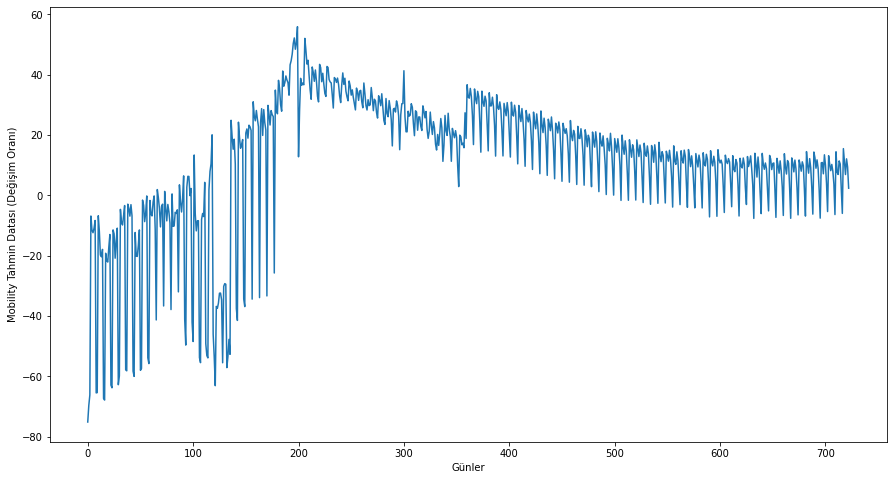

In [11]:
plt.rcParams["figure.figsize"] = (15,8)

mobility_future["y"].plot()

plt.xlabel("Günler")
plt.ylabel("Mobility Tahmin Datası (Değişim Oranı)")

#Vaka Tahmini

In [12]:
url = 'https://drive.google.com/file/d/1k0OGsRUiJD1wv_WE2RtO_KS4B3SbzeeN/view?usp=sharing'
url_vaka = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

vaka = pd.read_csv(url_vaka)

In [13]:
vaka_train = mobility_future
vaka_train = vaka_train.rename(columns={'y': 'mobility_future'})
vaka_train["y"] = vaka["vaka"]#kütüphane tahmin edilecek değerin kolonunun y tarihlerinin de ds olmasını istiyor
vaka_train['y_orig'] = vaka_train['y']  
vaka_train['y'] = np.log(vaka_train['y'])

In [ ]:
model_new = Prophet()
model_new.add_regressor('mobility_future')#mobility datasına göre tahmin yapıyoruz
model_new.fit(vaka_train)
future_data = vaka_train[['mobility_future' , 'ds']]
vaka_future = model_new.predict(future_data)#tahmin ettiğimiz datayı bulduk

In [15]:
vaka_train["vaka_future"] =  np.exp(vaka_future["yhat"])#yhat tahmin değerimiz bunu future datası olarak ekledik

#2 Senelik vaka tahminimiz

Text(0, 0.5, 'Vaka Sayıları')

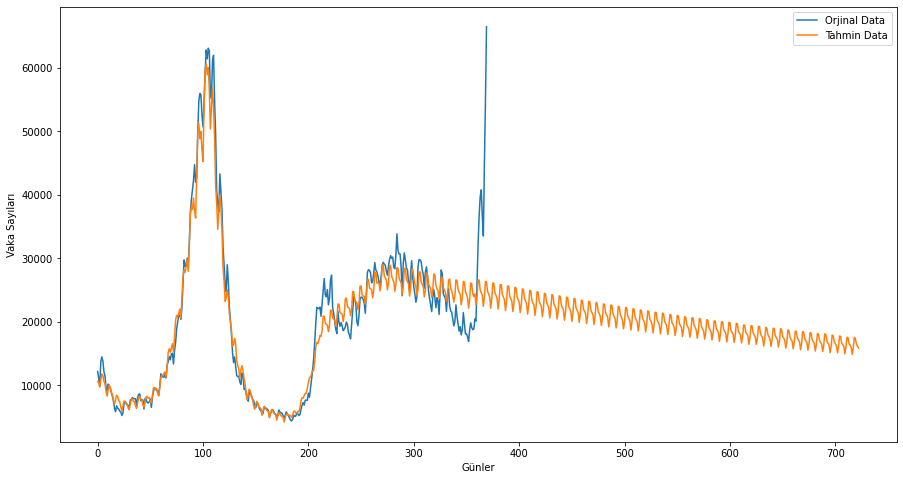

In [16]:
plt.rcParams["figure.figsize"] = (15,8)

t = pd.DataFrame()

t["Orjinal Data"] = vaka_train["y_orig"]
t["Tahmin Data"] = vaka_train["vaka_future"]

t.plot()

plt.xlabel("Günler")
plt.ylabel("Vaka Sayıları")

#İl Datası

In [17]:
url = 'https://drive.google.com/file/d/1tb3TXAfuY9YKKQ_R8zDpBkE-9_OgdDSO/view?usp=sharing'
url_nufus = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

nufus_il_temp = pd.read_csv(url_nufus)
for i in range(0,81):
  nufus_il_temp.iloc[i,0] = nufus_il_temp.iloc[i,0].split("-")[0]

nufus_il = pd.DataFrame(nufus_il_temp["il"])
nufus_il["nufus"] = nufus_il_temp["erkek"] + nufus_il_temp["kadın"]

url = "https://drive.google.com/file/d/1U-WVGDb9IdyAlPg7CztQDndD5mQFSYdM/view?usp=sharing"
haftalik_vaka = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

yuzbinde_haftalik_vaka = pd.read_csv(haftalik_vaka)

#tarihleri pandas date için hazırlamak
for i in range(yuzbinde_haftalik_vaka.shape[0]):
  temp = yuzbinde_haftalik_vaka.iloc[i,0]
  temp = temp.split('-')
  temp = temp[2] + '-' + temp[1] + '-' + temp[0]
  yuzbinde_haftalik_vaka.iloc[i,0] = temp
  temp = yuzbinde_haftalik_vaka.iloc[i,1]
  temp = temp.split('-')
  temp = temp[2] + '-' + temp[1] + '-' + temp[0]
  yuzbinde_haftalik_vaka.iloc[i,1] = temp

yuzbinde_haftalik_vaka.tarih_baslangic = pd.to_datetime(yuzbinde_haftalik_vaka.tarih_baslangic)
yuzbinde_haftalik_vaka.tarih_bitis = pd.to_datetime(yuzbinde_haftalik_vaka.tarih_bitis)

#Yüzbin'de oran tahmini için data hazırlandı ve illere bölündü

In [18]:
temp_df = pd.DataFrame(vaka_train[(vaka_train['ds'] >= "2021-02-08") & (vaka_train['ds'] <= "2021-12-17")]["ds"])
temp_df = temp_df.reset_index()
temp_df.drop('index', inplace=True, axis=1)
temp_df["yuzbin_kiside_haftalik_vaka_sayisi"] = np.nan


il_vaka = list()


for i in range(81):
  temp = yuzbinde_haftalik_vaka[yuzbinde_haftalik_vaka["il"] == nufus_il.iloc[i,0]]
  for j in range(temp.shape[0]):
    start = temp.iloc[j,0]
    k = temp_df[temp_df["ds"] == start].index[0]
    for l in range(7):
      temp_df.iloc[k,1] = temp.iloc[j,3]
      k+=1
  il_vaka.append([nufus_il.iloc[i,0] , nufus_il.iloc[i,1] , temp_df.copy()])

##Tahmin Yapıldı

In [ ]:
for i in range(81):
  il_vaka[i][2] = il_vaka[i][2].rename(columns={'yuzbin_kiside_haftalik_vaka_sayisi': 'y'})#prophet date preprocessing
  model = Prophet(daily_seasonality=True)
  model.fit(il_vaka[i][2])
  future_data = model.make_future_dataframe(periods=365+7, freq = 'D')
  forecast_data = model.predict(future_data)
  il_vaka[i][2] = forecast_data[['ds', 'yhat']]#tahmin datası

İller için tahmin edilen yüzbinde vaka sayısınden o ilin vaka sayısını bulduk ve bu vakaların toplamı alındı. İllerin toplamında çıkan vaka ile Türkiye için tahmin edilen vaka sayısı oranlandı (Türkiye geneli vaka / illerin toplamında çıkan vaka) bu katsayı ile illerde çıkan yüzbinde vaka sayısı çarpıldı ve iki verinin birbiri ile uyuşması sağlandı.

In [ ]:
for i in range(81):
  for j in range(il_vaka[i][2].shape[0]):
    if il_vaka[i][2].iloc[j,1] < 0:
      il_vaka[i][2].iloc[j,1] = 0


for i in range(il_vaka[0][2].shape[0]):
  vaka = 0
  for j in range(81):
    vaka += (il_vaka[j][1] / 100000) * il_vaka[j][2].iloc[i,1]
  katsayi = vaka_train[vaka_future["ds"] == il_vaka[0][2]["ds"][i]]["vaka_future"].values[0] / vaka
  for j in range(81):
    il_vaka[j][2].iloc[i,1] = il_vaka[j][2].iloc[i,1] * katsayi

In [ ]:
url = "https://drive.google.com/file/d/1wMfpJc7yO6iQij69YVlQp_WYTmuHaGUy/view?usp=sharing"
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
iller = geo.read_file(url)

for i in range(81):
  iller["NAME_1"][i] = nufus_il["il"][i]

In [22]:
def f(start):
    print('start date: {}'.format(start))


def cizdir_update(Sehir="" , date = widgets.DatePicker(
    description='Date',
    disabled=False
)):
  f = False
  d_f = False

  if date is not None:
    d_f = True

  if d_f == True:
    harita = iller[["NAME_1" , "HASC_1" , "geometry"]].copy()
    harita["vaka_yuzbin"] = np.zeros(81)
    for i in range(81):
      harita.iloc[i,3] = il_vaka[i][2][il_vaka[i][2]["ds"] == str(date)]["yhat"].values[0]
    ax = harita.plot(figsize=(15,15), column='vaka_yuzbin', scheme='userdefined', legend=True ,cmap = 'YlOrRd' , classification_kwds={'bins':[25,50,75,150]})
    ax.set_axis_off()
    ax.set_title("Türkiye Geneli Vaka Sayısı : {}\nYüz Bin Kişide Vaka Sayısı Haritası".format(int(vaka_train[vaka_train["ds"] == str(date)]["vaka_future"].values[0])))
    for i in range(81):
      if il_vaka[i][0] == Sehir:
        df = il_vaka[i][2]
        nuf = il_vaka[i][1]
        f = True
        break
    if f == True:
      yuzbin = df[df["ds"] == str(date)]["yhat"].values[0]
      vaka_sayisi = (nuf / 100000) * yuzbin
      vaka_sayisi = int(vaka_sayisi)
      print("\n\n{} vaka sayısı = {}\n\n\n".format(Sehir,vaka_sayisi))
    else:
        print("\n\n")
    f = False

In [23]:
widgets.interact(cizdir_update, Sehir = nufus_il["il"])

interactive(children=(Dropdown(description='Sehir', options=('Adana', 'Adıyaman', 'Afyon', 'Ağrı', 'Aksaray', …

<function __main__.cizdir_update>